<a href="https://colab.research.google.com/github/Alx-a-cod/MLiterallyConfused/blob/main/ML_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
 # ==== file upload from PC ====
from google.colab import files
uploaded = files.upload()

Saving diabetes.csv to diabetes (1).csv


In [12]:
# ==== libraries import ====
import numpy as np
import pandas as pd
# ==== dependencies import ====
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns



In [18]:
# ==== load dataset ====

filename = "diabetes.csv"

df = pd.read_csv("diabetes.csv")

# ==== check both English (,) and European (;) separators ====
try:
    df = pd.read_csv(filename, sep=',')
    if df.shape[1] == 1: # if everything gets lumped in one column
        raise ValueError("Possible separator issue. Check your file and retry?")
except Exception:
    df = pd.read_csv(filename, sep=';')

# === dataset overview ===

print(f"Dataset loaded successfully: {filename}")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

print("Columns:")
print(df.columns.tolist(), "\n")

print("Missing values per column:")
print(df.isna().sum(), "\n") # returns a DataFrame of booleans: True if it’s NaN, False if it’s a valid number or string

print("Preview:")
pd.set_option('display.max_columns', None)
df.head()

Dataset loaded successfully: diabetes.csv
Shape: 1199 rows × 9 columns

Columns:
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'] 

Missing values per column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64 

Preview:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.63,50,1
1,1,85,66,29,0,26.6,0.35,31,0
2,8,183,64,0,0,23.3,0.67,32,1
3,1,89,66,23,94,28.1,0.17,21,0
4,0,137,40,35,168,43.1,2288.00,33,1


In [15]:
# ==== statistics & health-check about the Dataset ====

summary = df.describe().T
summary['missing'] = df.isna().sum()
display(summary.round(2)) # display wrap for prettier dataframes: renders as clean HTML table in Colab instead of print text dump


,count,mean,std,min,25%,50%,75%,max,missing
Pregnancies,1199.0,4.62,3.11,0.00,2.0,4.00,7.00,17.0,0
Glucose,1199.0,137.04,34.73,0.00,108.0,143.00,164.00,199.0,0
BloodPressure,1199.0,73.96,17.62,0.00,68.0,76.00,84.50,122.0,0
SkinThickness,1199.0,24.93,14.32,0.00,17.5,29.00,35.00,99.0,0
Insulin,1199.0,87.53,100.99,0.00,0.0,82.00,140.00,846.0,0
BMI,1199.0,33.13,6.99,0.00,29.7,33.10,37.45,67.1,0
DiabetesPedigreeFunction,1199.0,52.54,265.24,0.08,0.3,0.62,0.72,2329.0,0
Age,1199.0,40.10,14.01,21.00,26.5,41.00,51.00,81.0,0
Outcome,1199.0,0.40,0.49,0.00,0.0,0.00,1.00,1.0,0


Replaced 5 zeros in 'Glucose' with NaN.
Replaced 35 zeros in 'BloodPressure' with NaN.
Replaced 227 zeros in 'SkinThickness' with NaN.
Replaced 493 zeros in 'Insulin' with NaN.
Replaced 11 zeros in 'BMI' with NaN.
Replaced 0 zeros in 'Age' with NaN.

Missing values after zero replacement:


,Missing Values
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,493
BMI,11
Age,0



Data split shapes: Train: (839, 8), Val: (180, 8), Test: (180, 8)

Preprocessing pipeline applied (median imputation + scaling + PCA).
Shape after preprocessing (train): (839, 7)
Training rows flagged as potential outliers (|z|>3): 56

PCA Components (full matrix):


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
PC1,0.378,0.431,0.416,0.357,0.176,0.372,-0.020,0.449
PC2,-0.329,0.019,-0.134,0.312,0.528,0.309,0.556,-0.305
PC3,-0.218,-0.232,-0.032,0.501,-0.352,0.483,-0.479,-0.246
PC4,-0.044,0.161,-0.279,-0.059,0.665,-0.088,-0.663,-0.029
PC5,0.711,-0.449,-0.472,0.214,0.092,0.043,0.109,0.032
PC6,0.158,-0.520,0.620,-0.341,0.298,0.222,-0.088,-0.241
PC7,0.158,0.322,-0.305,-0.574,-0.145,0.632,0.024,-0.170



Explained variance by each PC:


,PC,Explained Variance Ratio,Cumulative Variance
0,PC1,0.409,0.409
1,PC2,0.153,0.562
2,PC3,0.128,0.689
3,PC4,0.106,0.796
4,PC5,0.073,0.869
5,PC6,0.057,0.926
6,PC7,0.045,0.971


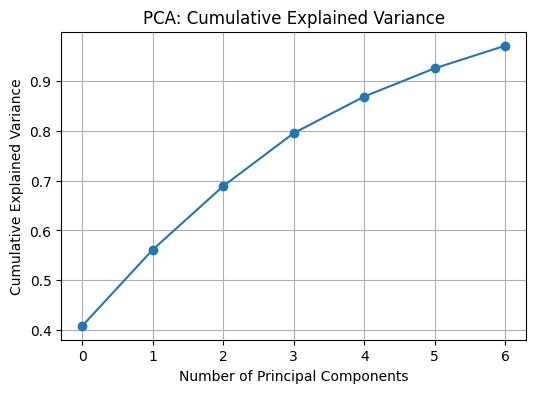

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-0.616815,-0.284520,-0.343903,0.312222,-0.419003,-0.578876,0.085887
1,0.057808,0.478686,0.467930,0.250049,-1.217213,-0.715526,0.579005
2,0.397518,-0.382514,-0.923776,0.974781,1.238666,-1.167592,-0.439428
3,4.107972,-0.054834,0.050111,-0.009929,-0.243662,0.281255,0.049752
4,-0.259386,0.148650,-0.075932,0.373683,-0.946766,-0.828282,0.220450



Any NaN after preprocessing? 0

Summary stats after preprocessing (train set):


,count,mean,std,min,25%,50%,75%,max
PC1,839.0,0.0,1.81,-4.63,-1.21,-0.16,1.06,4.15
PC2,839.0,0.0,1.11,-2.67,-0.55,-0.32,0.25,10.69
PC3,839.0,-0.0,1.01,-6.98,-0.38,-0.09,0.31,5.10
PC4,839.0,-0.0,0.92,-4.79,-0.19,-0.05,0.27,7.69
PC5,839.0,-0.0,0.77,-3.00,-0.37,-0.19,0.33,3.33
PC6,839.0,-0.0,0.67,-4.63,-0.40,-0.10,0.32,2.82
PC7,839.0,0.0,0.60,-4.43,-0.20,0.04,0.19,2.26


In [29]:

# =========================
# DATA PREPROCESSING
# =========================

import numpy as np
import pandas as pd

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# ==== 0. original copy to avoid overwriting ====

df_clean = df.copy()

# ==== 1. Replaced impossible zeros with NaN ====

target = "Outcome"
zeros_as_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "Age"]
log_transform = []

# --- SAFETY CHECK: see if the dataset is missing any column names ---
missing_cols = set(zeros_as_missing) - set(df_clean.columns)
if missing_cols:
    print("Warning! Columns expected for zero-replacement not found:", missing_cols)

if zeros_as_missing is not None:
    for col in zeros_as_missing:
        if col in df_clean.columns:
            missing_count = (df_clean[col] == 0).sum()
            df_clean[col] = df_clean[col].replace(0, np.nan)
            print(f"Replaced {missing_count} zeros in '{col}' with NaN.")

    print("\nMissing values after zero replacement:")
    display(df_clean[zeros_as_missing].isna().sum().to_frame("Missing Values"))

    # Optional log-transform for skewed features
    if log_transform:
        for col in log_transform:
            if col in df_clean.columns:
                df_clean[col] = np.log1p(df_clean[col])
                print(f"Applied log1p transform to '{col}'")

# === 2. Splitting dataset before imputation/scaling (leakage prevention)===

X = df_clean.drop(target, axis=1)
y = df_clean[target]

# 1st split: train+val vs test
x_trainval, x_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# 2nd split: train vs val (approx. 70/15/15)
x_train, x_val, y_train, y_val = train_test_split(
    x_trainval, y_trainval, test_size=0.1765, stratify=y_trainval, random_state=42
)

print(f"\nData split shapes: Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")

# ==== 3. Preprocessing pipeline: median imputation + scaling + PCA ====
numeric_features = x_train.columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # handles NaN robustly
    ("scaler", StandardScaler()),                   # zero mean, unit variance
    ("pca", PCA(n_components=0.95))                 # keeps 95% of variance
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features)
], remainder="drop")

# Fit/transform training data; transform val/test
x_train_p = preprocessor.fit_transform(x_train)
x_val_p = preprocessor.transform(x_val)
x_test_p = preprocessor.transform(x_test)

print("\nPreprocessing pipeline applied (median imputation + scaling + PCA).")
print("Shape after preprocessing (train):", x_train_p.shape)

# ==== 4. Outlier detection on training data ====
X_train_scaled_df = pd.DataFrame(
    preprocessor.named_transformers_['num'].named_steps['scaler'].transform(
        SimpleImputer(strategy="median").fit_transform(x_train)
    ),
    columns=numeric_features
)

z_scores = np.abs(stats.zscore(X_train_scaled_df))
outlier_flags = (z_scores > 3).any(axis=1)
print(f"Training rows flagged as potential outliers (|z|>3): {outlier_flags.sum()}")

# ==== 5. PCA inspection: all components ====
pca = preprocessor.named_transformers_['num'].named_steps['pca']

# PCA component matrix
pca_components_df = pd.DataFrame(
    pca.components_,
    columns=numeric_features,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)
print("\nPCA Components (full matrix):")
display(pca_components_df.round(3))

# Explained variance
explained_df = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(pca.n_components_)],
    "Explained Variance Ratio": np.round(pca.explained_variance_ratio_, 3),
    "Cumulative Variance": np.round(np.cumsum(pca.explained_variance_ratio_), 3)
})
print("\nExplained variance by each PC:")
display(explained_df)

# Plot cumulative explained variance
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Cumulative Explained Variance")
plt.grid(True)
plt.show()

# Optional: transformed train set in PCA space
X_train_pca_df = pd.DataFrame(
    x_train_p,
    columns=[f"PC{i+1}" for i in range(x_train_p.shape[1])]
)
display(X_train_pca_df.head())

# ==== 6. Sanity checks ====
print("\nAny NaN after preprocessing?", np.isnan(x_train_p).sum())
print("\nSummary stats after preprocessing (train set):")
display(X_train_pca_df.describe().T.round(2))

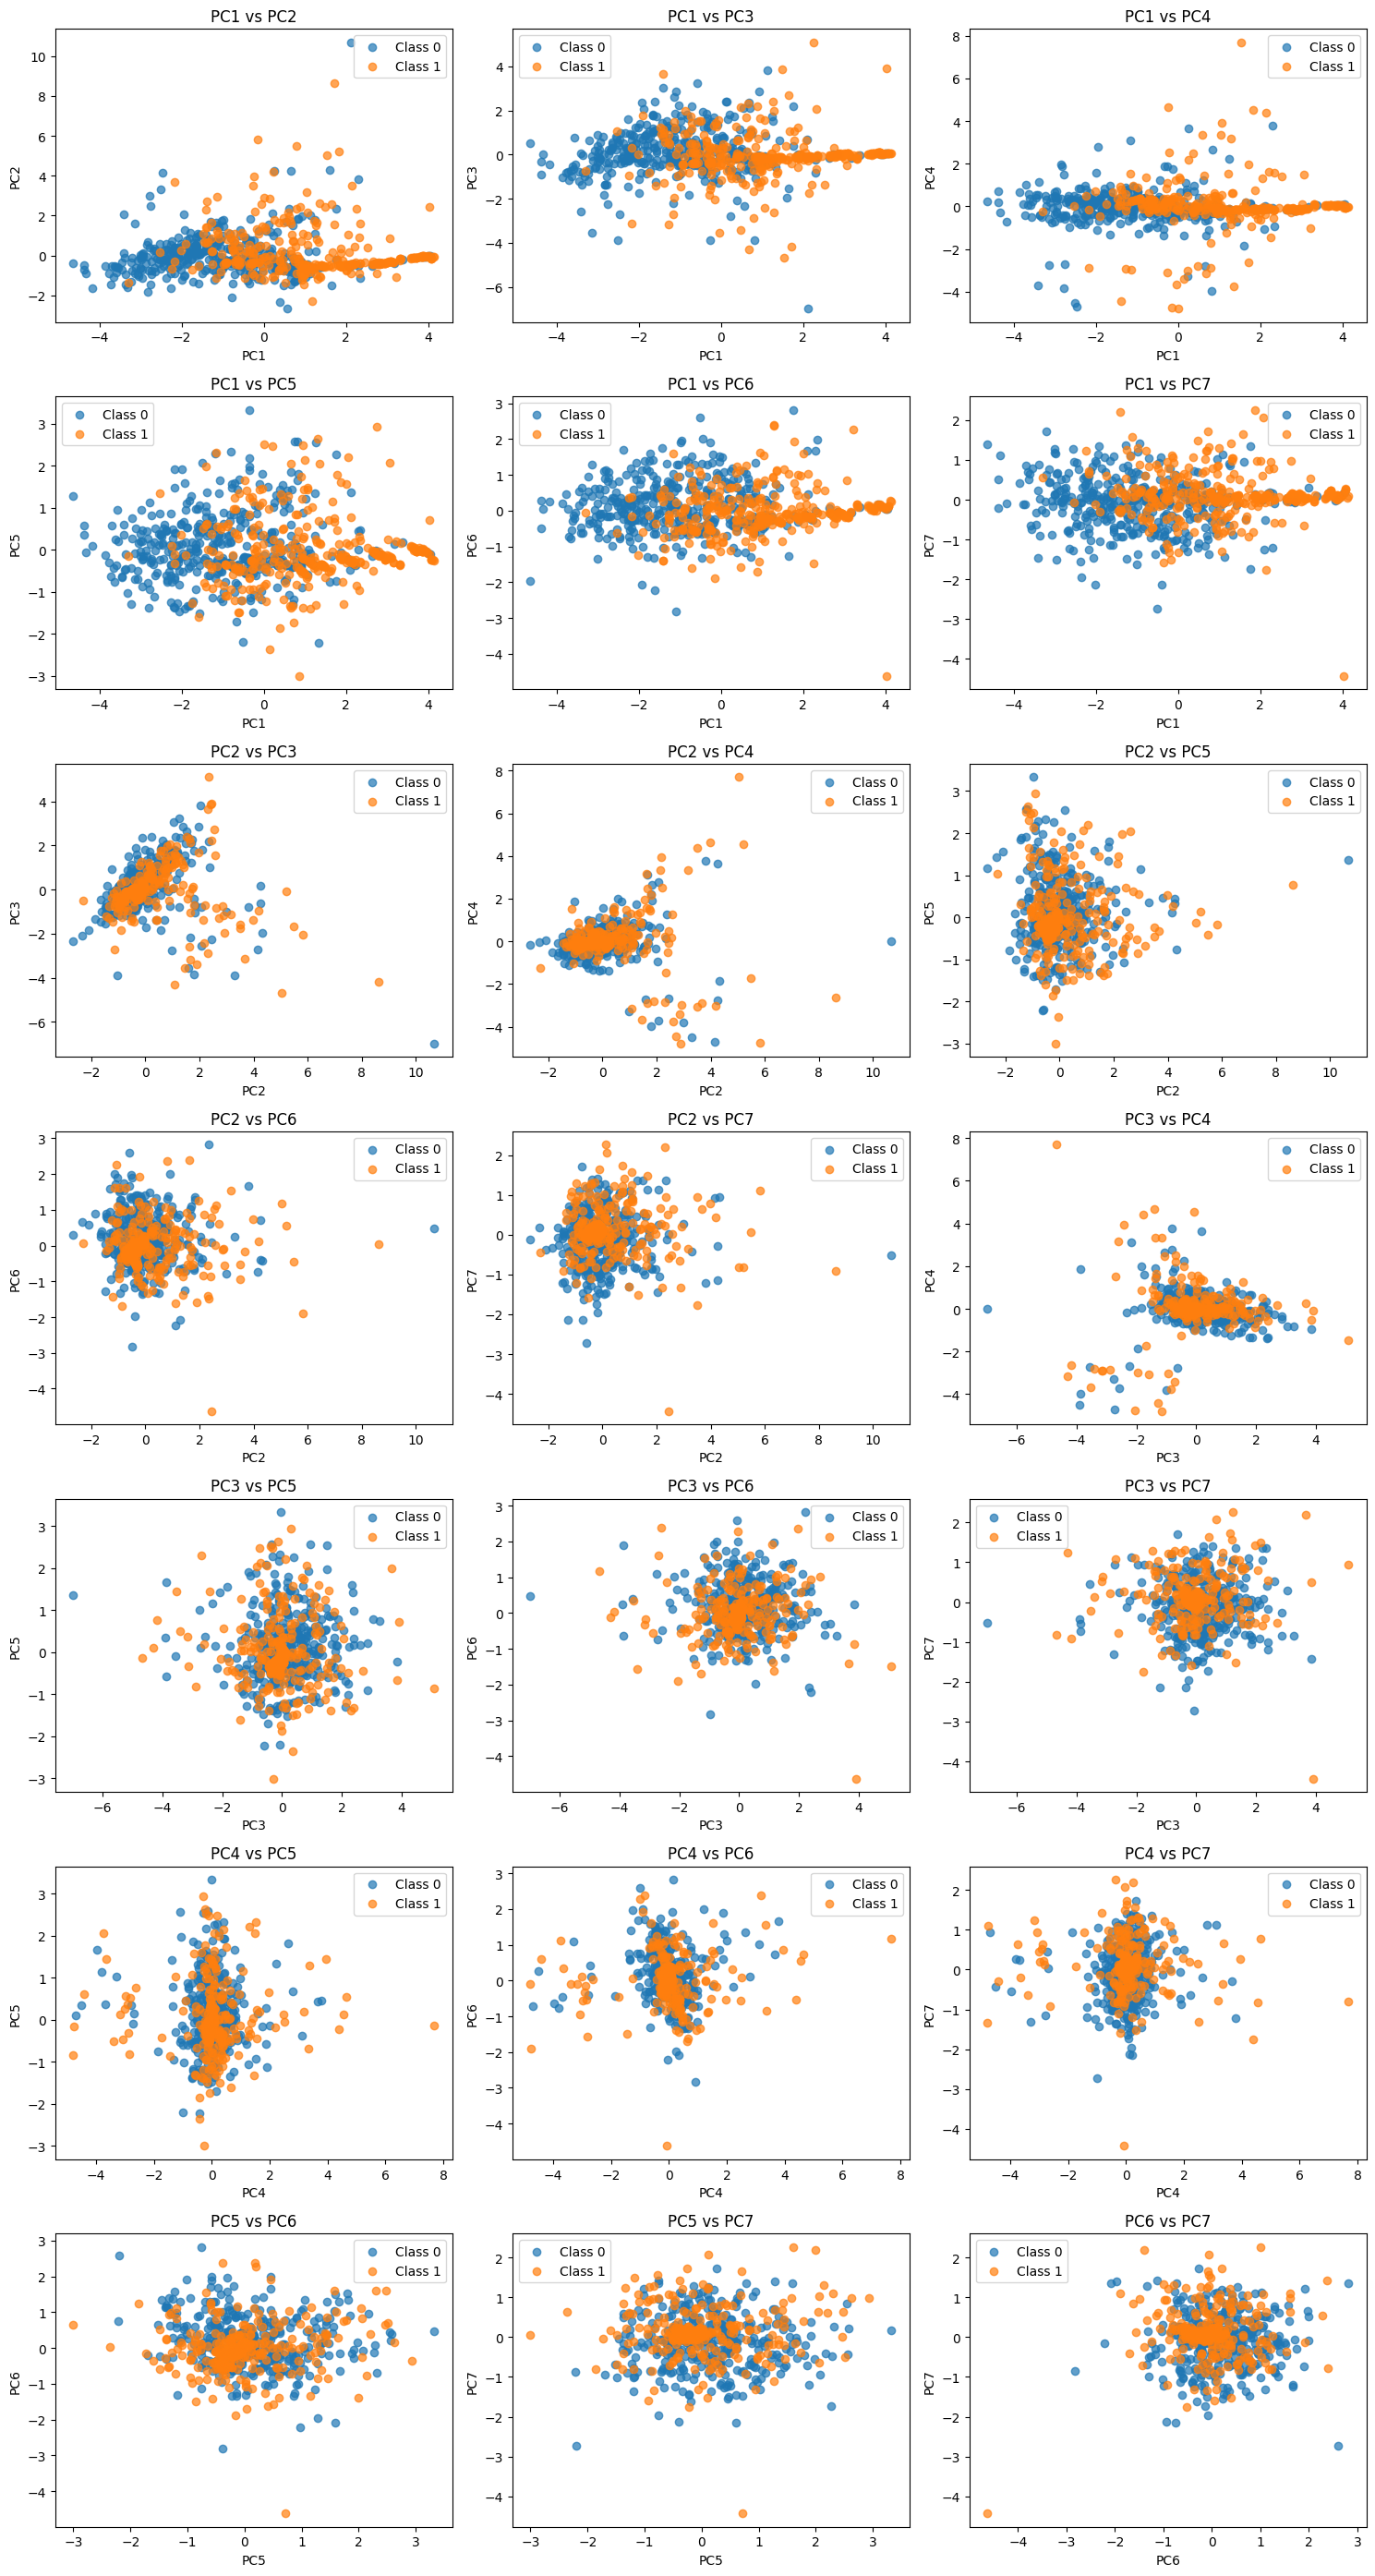

In [30]:
# =========================
# Optional: PCA visualization by class
# =========================

import itertools

# Take transformed training set in PCA space
X_train_pca_df = pd.DataFrame(
    x_train_p,
    columns=[f"PC{i+1}" for i in range(x_train_p.shape[1])]
)
y_train_array = y_train.values

# Plot all PC pairs
pc_indices = range(x_train_p.shape[1])
pairs = list(itertools.combinations(pc_indices, 2))  # all 2-PC pairs

num_pairs = len(pairs)
ncols = 3
nrows = int(np.ceil(num_pairs / ncols))

plt.figure(figsize=(ncols*5, nrows*4))

for i, (p1, p2) in enumerate(pairs):
    plt.subplot(nrows, ncols, i+1)
    for cls in np.unique(y_train_array):
        plt.scatter(
            X_train_pca_df.iloc[y_train_array==cls, p1],
            X_train_pca_df.iloc[y_train_array==cls, p2],
            label=f"Class {cls}",
            alpha=0.7
        )
    plt.xlabel(f"PC{p1+1}")
    plt.ylabel(f"PC{p2+1}")
    plt.title(f"PC{p1+1} vs PC{p2+1}")
    plt.legend()

plt.tight_layout()
plt.show()



=== GaussianNB ===

=== LogisticRegression ===
Best params: {'C': 0.01}

=== DecisionTree ===
Best params: {'max_depth': 3, 'min_samples_split': 2}

=== RandomForest ===
Best params: {'max_depth': None, 'n_estimators': 200}

=== SVM ===
Best params: {'C': 1, 'kernel': 'rbf'}


,Model,Train Accuracy,Val Accuracy,Test Accuracy,Train F1,Val F1,Test F1,Train ROC-AUC,Val ROC-AUC,Test ROC-AUC,Training Time (s),Fitted Model
2,DecisionTree,0.777,0.728,0.733,0.719,0.652,0.667,0.830,0.751,0.779,0.534,"DecisionTreeClassifier(max_depth=3, random_sta..."
3,RandomForest,0.995,0.711,0.767,0.994,0.649,0.696,1.000,0.806,0.814,20.401,"(DecisionTreeClassifier(max_features='sqrt', r..."
4,SVM,0.802,0.722,0.778,0.728,0.638,0.697,0.858,0.761,0.821,4.484,"SVC(C=1, probability=True, random_state=42)"
1,LogisticRegression,0.769,0.700,0.761,0.698,0.635,0.677,0.821,0.745,0.819,2.780,"LogisticRegression(C=0.01, max_iter=1000, solv..."
0,GaussianNB,0.749,0.711,0.722,0.632,0.594,0.621,0.809,0.716,0.787,0.007,GaussianNB()


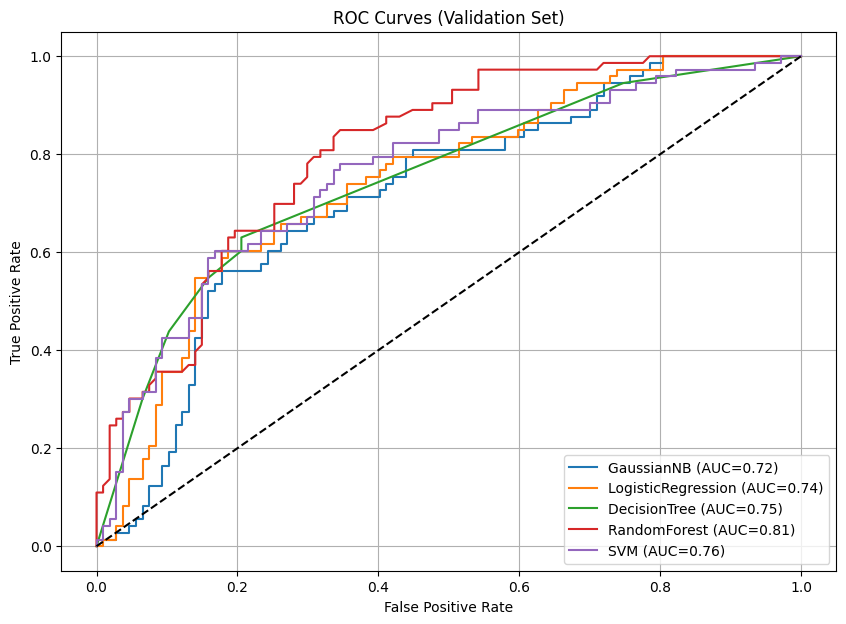

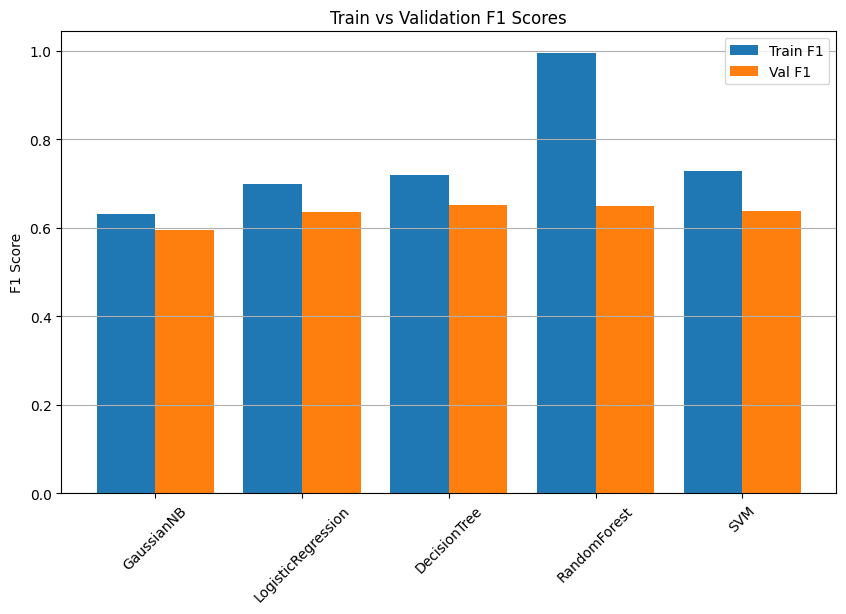

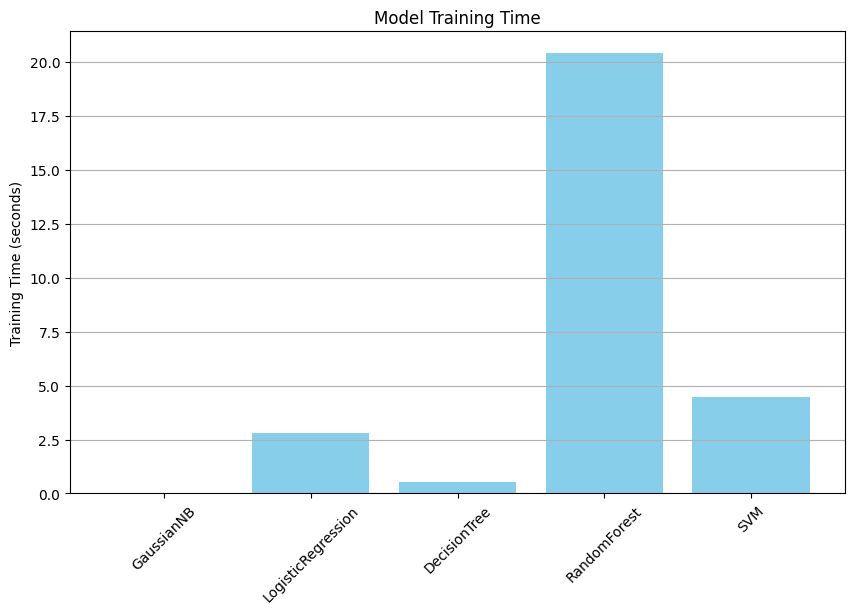

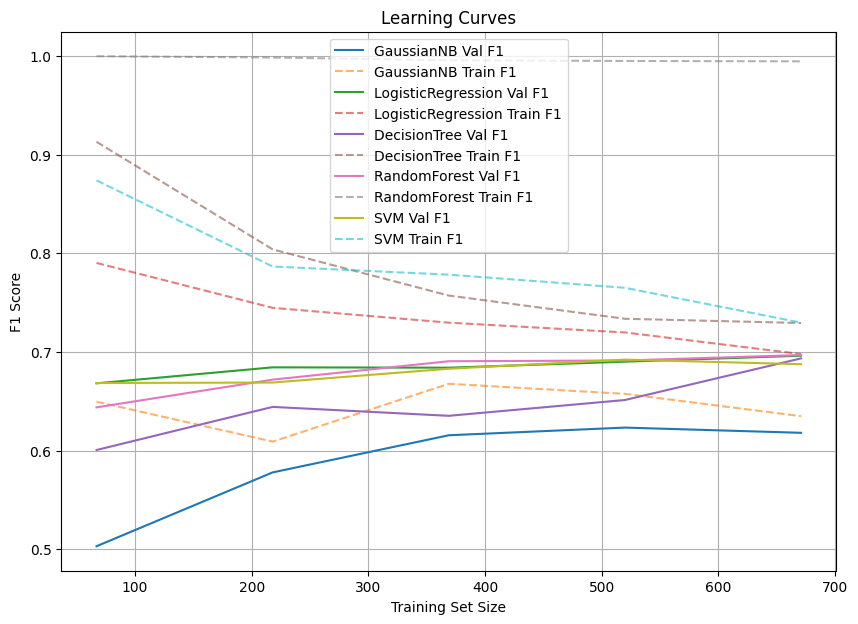


Confusion Matrix - GaussianNB (Validation)
[[90 17]
 [35 38]]

Classification Report - GaussianNB (Validation)
              precision    recall  f1-score   support

           0       0.72      0.84      0.78       107
           1       0.69      0.52      0.59        73

    accuracy                           0.71       180
   macro avg       0.71      0.68      0.68       180
weighted avg       0.71      0.71      0.70       180


Confusion Matrix - LogisticRegression (Validation)
[[79 28]
 [26 47]]

Classification Report - LogisticRegression (Validation)
              precision    recall  f1-score   support

           0       0.75      0.74      0.75       107
           1       0.63      0.64      0.64        73

    accuracy                           0.70       180
   macro avg       0.69      0.69      0.69       180
weighted avg       0.70      0.70      0.70       180


Confusion Matrix - DecisionTree (Validation)
[[85 22]
 [27 46]]

Classification Report - DecisionTree (Va

In [35]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, auc, classification_report
)

# ===== 1. Train, tune, and evaluate all models =====
results = []

def get_probs(mdl, X):
    """Return probabilities or decision function values for ROC-AUC, if available"""
    if hasattr(mdl, "predict_proba"):
        return mdl.predict_proba(X)[:,1]
    elif hasattr(mdl, "decision_function"):
        return mdl.decision_function(X)
    else:
        return None

for name, (model, param_grid) in models.items():
    print(f"\n=== {name} ===")

    # Grid search if hyperparameters provided
    if param_grid:
        gs = GridSearchCV(model, param_grid, cv=5, scoring="f1", n_jobs=-1)
        start_time = time.time()
        gs.fit(x_train_p, y_train)
        train_time = time.time() - start_time
        best_model = gs.best_estimator_
        print(f"Best params: {gs.best_params_}")
    else:
        start_time = time.time()
        model.fit(x_train_p, y_train)
        train_time = time.time() - start_time
        best_model = model

    # Store fitted model for plots and metrics
    model_fitted = clone(best_model)
    model_fitted.fit(x_train_p, y_train)

    # Predictions
    y_train_pred = model_fitted.predict(x_train_p)
    y_val_pred   = model_fitted.predict(x_val_p)
    y_test_pred  = model_fitted.predict(x_test_p)

    # Probabilities for ROC-AUC
    y_train_prob = get_probs(model_fitted, x_train_p)
    y_val_prob   = get_probs(model_fitted, x_val_p)
    y_test_prob  = get_probs(model_fitted, x_test_p)

    # Metrics
    metrics = {
        "Model": name,
        "Train Accuracy": round(accuracy_score(y_train, y_train_pred),3),
        "Val Accuracy": round(accuracy_score(y_val, y_val_pred),3),
        "Test Accuracy": round(accuracy_score(y_test, y_test_pred),3),
        "Train F1": round(f1_score(y_train, y_train_pred),3),
        "Val F1": round(f1_score(y_val, y_val_pred),3),
        "Test F1": round(f1_score(y_test, y_test_pred),3),
        "Train ROC-AUC": round(roc_auc_score(y_train, y_train_prob),3) if y_train_prob is not None else None,
        "Val ROC-AUC": round(roc_auc_score(y_val, y_val_prob),3) if y_val_prob is not None else None,
        "Test ROC-AUC": round(roc_auc_score(y_test, y_test_prob),3) if y_test_prob is not None else None,
        "Training Time (s)": round(train_time,3),
        "Fitted Model": model_fitted
    }

    results.append(metrics)

# Summary DataFrame
results_df = pd.DataFrame(results)
display(results_df.sort_values("Val F1", ascending=False))

# ===== 2. ROC curves (Validation set) =====
plt.figure(figsize=(10,7))
for r in results:
    model = r["Fitted Model"]
    probs = get_probs(model, x_val_p)
    if probs is not None:
        fpr, tpr, _ = roc_curve(y_val, probs)
        roc_auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{r['Model']} (AUC={roc_auc_val:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Validation Set)")
plt.legend()
plt.grid(True)
plt.show()

# ===== 3. Train vs Validation F1 =====
train_f1 = [r["Train F1"] for r in results]
val_f1   = [r["Val F1"] for r in results]
models_names = [r["Model"] for r in results]

x = np.arange(len(models_names))
plt.figure(figsize=(10,6))
plt.bar(x - 0.2, train_f1, width=0.4, label="Train F1")
plt.bar(x + 0.2, val_f1, width=0.4, label="Val F1")
plt.xticks(x, models_names, rotation=45)
plt.ylabel("F1 Score")
plt.title("Train vs Validation F1 Scores")
plt.legend()
plt.grid(axis='y')
plt.show()

# ===== 4. Training Time =====
training_times = [r["Training Time (s)"] for r in results]
plt.figure(figsize=(10,6))
plt.bar(models_names, training_times, color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("Training Time (seconds)")
plt.title("Model Training Time")
plt.grid(axis='y')
plt.show()

# ===== 5. Learning Curves =====
plt.figure(figsize=(10,7))
for r in results:
    name = r["Model"]
    model = clone(r["Fitted Model"])
    train_sizes, train_scores, val_scores = learning_curve(
        model, x_train_p, y_train, cv=5, scoring="f1",
        train_sizes=np.linspace(0.1,1.0,5), n_jobs=-1
    )
    plt.plot(train_sizes, val_scores.mean(axis=1), label=f"{name} Val F1")
    plt.plot(train_sizes, train_scores.mean(axis=1), linestyle='--', alpha=0.6, label=f"{name} Train F1")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.title("Learning Curves")
plt.legend()
plt.grid(True)
plt.show()

# ===== 6. Confusion Matrices (Validation) =====
for r in results:
    model = r["Fitted Model"]
    y_val_pred = model.predict(x_val_p)
    cm = confusion_matrix(y_val, y_val_pred)
    print(f"\nConfusion Matrix - {r['Model']} (Validation)")
    print(cm)
    print(f"\nClassification Report - {r['Model']} (Validation)")
    print(classification_report(y_val, y_val_pred))


In [36]:
# ===== 7. Final Summary Table =====
summary_cols = [
    "Model",
    "Train Accuracy", "Val Accuracy", "Test Accuracy",
    "Train F1", "Val F1", "Test F1",
    "Train ROC-AUC", "Val ROC-AUC", "Test ROC-AUC",
    "Training Time (s)"
]

summary_df = results_df[summary_cols].sort_values("Val F1", ascending=False)
summary_df.reset_index(drop=True, inplace=True)

print("\n===== Model Performance Summary =====")
display(summary_df.style.format({
    "Train Accuracy": "{:.3f}",
    "Val Accuracy": "{:.3f}",
    "Test Accuracy": "{:.3f}",
    "Train F1": "{:.3f}",
    "Val F1": "{:.3f}",
    "Test F1": "{:.3f}",
    "Train ROC-AUC": "{:.3f}",
    "Val ROC-AUC": "{:.3f}",
    "Test ROC-AUC": "{:.3f}",
    "Training Time (s)": "{:.2f}"
}).bar(subset=["Val F1", "Test F1"], color='lightgreen'))



===== Model Performance Summary =====


,Model,Train Accuracy,Val Accuracy,Test Accuracy,Train F1,Val F1,Test F1,Train ROC-AUC,Val ROC-AUC,Test ROC-AUC,Training Time (s)
0,DecisionTree,0.777,0.728,0.733,0.719,0.652,0.667,0.830,0.751,0.779,0.53
1,RandomForest,0.995,0.711,0.767,0.994,0.649,0.696,1.000,0.806,0.814,20.40
2,SVM,0.802,0.722,0.778,0.728,0.638,0.697,0.858,0.761,0.821,4.48
3,LogisticRegression,0.769,0.700,0.761,0.698,0.635,0.677,0.821,0.745,0.819,2.78
4,GaussianNB,0.749,0.711,0.722,0.632,0.594,0.621,0.809,0.716,0.787,0.01
